<a href="https://colab.research.google.com/github/Jenny-high/Research/blob/main/intrinsic_inference_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Make sure to set the runtime to GPU: Runtime -> Change runtime type -> T4 GPU

You can upload your own images, then change the relevant code cells to load it and send it through the model.

In [1]:
# install the intrinsic decomposition repo from github
!pip install https://github.com/compphoto/Intrinsic/archive/main.zip

  Using cached https://github.com/compphoto/Intrinsic/archive/main.zip
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/CCareaga/MiDaS (to revision master) to /tmp/pip-install-rj8r86_c/altered-midas_64dbb1851b6944d5983c9fea6244e654
  Running command git clone --filter=blob:none --quiet https://github.com/CCareaga/MiDaS /tmp/pip-install-rj8r86_c/altered-midas_64dbb1851b6944d5983c9fea6244e654
  Resolved https://github.com/CCareaga/MiDaS to commit fb51e3af860d9430e9aaeb1d30edd3b6e2ac0538
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/CCareaga/chrislib (to revision main) to /tmp/pip-install-rj8r86_c/chrislib_a62df590e0bf402786fc863201ae8b0b
  Running command git clone --filter=blob:none --quiet https://github.com/CCareaga/chrislib /tmp/pip-install-rj8r86_c/chrislib_a62df590e0bf402786fc863201ae8b0b
  Resolved https://github.com/CCareaga/chrislib to commit 9a4c63f5fc5e7bbe62288f2777c527b706eb04d0
  Preparing metadata (setup.py) ... done


In [11]:
import torch
# import some helper functions from chrislib (will be installed by the intrinsic repo)
from chrislib.general import show, view, invert
from chrislib.data_util import load_from_url

# import model loading and running the pipeline
from intrinsic.pipeline import load_models, run_pipeline

import numpy as np
import skimage.transform as st
from google.colab import files
from PIL import Image
import io
from datetime import datetime
import os
import shutil

print("必要なすべてのライブラリがインポートされました。")

必要なすべてのライブラリがインポートされました。


In [3]:
# download the pretrained weights and return the model (may take a bit to download weights the first time)
intrinsic_model = load_models('v2')
print("Intrinsicモデルがロードされました。")

loading v2 weights


Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_main
Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_main
Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_main
Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_main


Intrinsicモデルがロードされました。


In [22]:
uploaded = files.upload()

# Initialize img1 and img2
img1 = None
img2 = None

image_files = list(uploaded.keys())

if len(image_files) >= 2:
    # Process the first image
    img_bytes1 = uploaded[image_files[0]]
    pil_img1 = Image.open(io.BytesIO(img_bytes1)).convert('RGB') # Ensure RGB format
    img1 = torch.from_numpy(np.array(pil_img1)).float() / 255.0 # Convert to numpy, then tensor and normalize
    img1 = img1.permute(2, 0, 1) # Permute to C, H, W

    # Process the second image
    img_bytes2 = uploaded[image_files[1]]
    pil_img2 = Image.open(io.BytesIO(img_bytes2)).convert('RGB') # Ensure RGB format
    img2 = torch.from_numpy(np.array(pil_img2)).float() / 255.0 # Convert to numpy, then tensor and normalize
    img2 = img2.permute(2, 0, 1) # Permute to C, H, W

    print(f"'{image_files[0]}' と '{image_files[1]}' が img1 および img2 に正常にアップロードおよびロードされました。")
elif len(image_files) == 1:
    # Process the first image
    img_bytes1 = uploaded[image_files[0]]
    pil_img1 = Image.open(io.BytesIO(img_bytes1)).convert('RGB') # Ensure RGB format
    img1 = torch.from_numpy(np.array(pil_img1)).float() / 255.0 # Convert to numpy, then tensor and normalize
    img1 = img1.permute(2, 0, 1) # Permute to C, H, W
    print(f"'{image_files[0]}' が img1 に正常にアップロードおよびロードされました。img2 が必要な場合は、別の画像をアップロードしてください。")
else:
    print("画像はアップロードされませんでした。")

Saving view5.png to view5 (3).png
'view5 (3).png' が img1 に正常にアップロードおよびロードされました。img2 が必要な場合は、別の画像をアップロードしてください。


img1 の固有分解が正常に実行されました。
各コンポーネントの計算が完了しました。
画像が表示されました。(左: Original, 中: Specular-free, 右: Albedo)
一時保存用フォルダを作成しました: /content/view5 (3)
フォルダへ保存: view5 (3)_original.png
フォルダへ保存: view5 (3)_specular-free.png
フォルダへ保存: view5 (3)_albedo_only.png
ZIP圧縮中...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ダウンロードを開始しました: view5 (3).zip


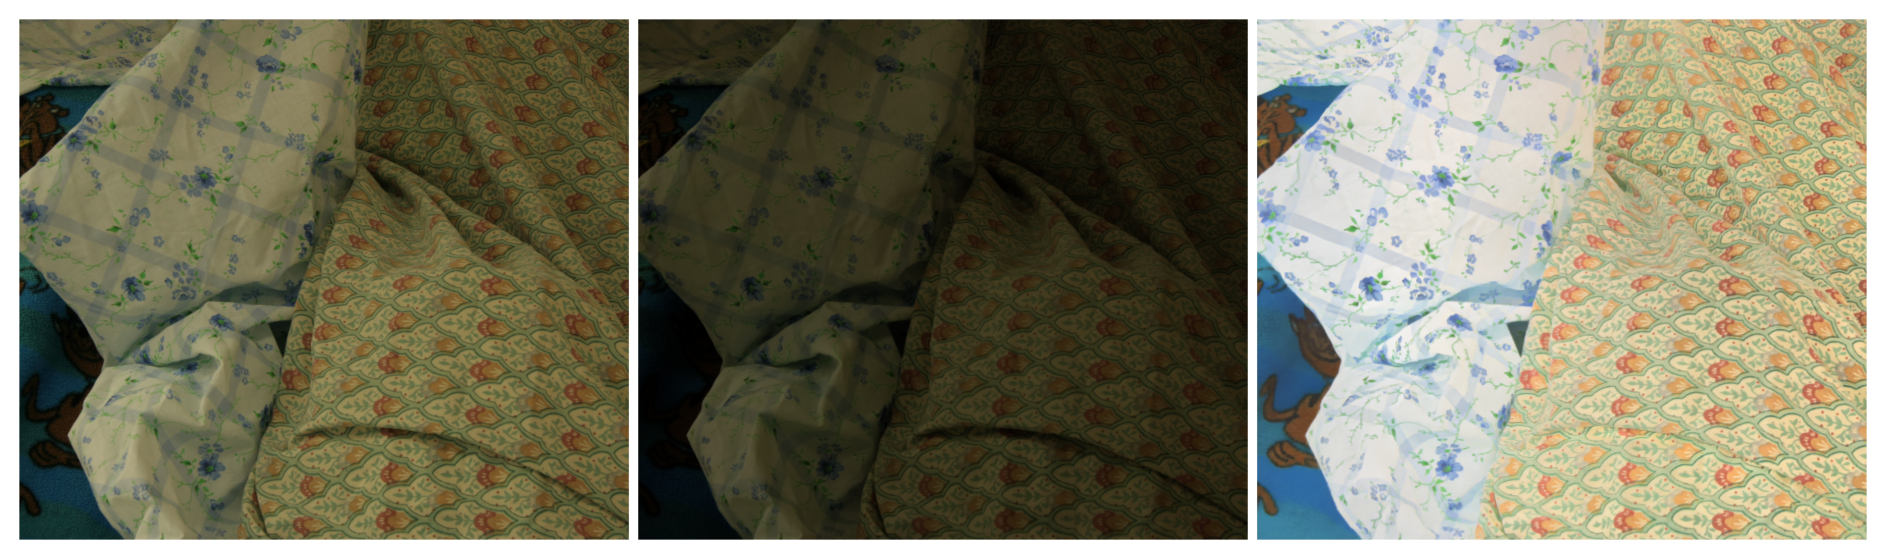

In [23]:
if img1 is not None:
    # --- 1. 固有分解パイプラインの実行 ---
    # (既存の処理: モデルを実行して結果を取得)
    result1 = run_pipeline(
        intrinsic_model,
        img1.permute(1, 2, 0).cpu().numpy(),
        device='cuda',
        resize_conf=None
    )
    print("img1 の固有分解が正常に実行されました。")

    # --- 2. コンポーネントの抽出と計算 ---
    img1_display = img1.permute(1, 2, 0).cpu().numpy()
    alb1 = view(result1['hr_alb'])
    dif1 = 1 - invert(result1['dif_shd'])

    # スペキュラーフリー画像の計算 (Albedo * Shading)
    spec_free_img1 = alb1 * dif1
    print("各コンポーネントの計算が完了しました。")

    # --- 3. 画像のリサイズと表示 ---
    target_h, target_w, _ = img1_display.shape
    alb1_resized = st.resize(alb1, (target_h, target_w), anti_aliasing=True)
    spec_free_img1_resized = st.resize(spec_free_img1, (target_h, target_w), anti_aliasing=True)

    # 結果の表示
    show([img1_display, spec_free_img1_resized, alb1_resized], size=(30, 7))
    print("画像が表示されました。(左: Original, 中: Specular-free, 右: Albedo)")

    # --- 4. 保存とダウンロードの準備 ---

    # ファイル名のベースを取得 (例: "Bowling2")
    original_filename_base = os.path.splitext(image_files[0])[0]

    # Colab内の一時保存用フォルダを作成 (例: /content/Bowling2)
    local_tmp_dir = f"/content/{original_filename_base}"

    # 既にフォルダがある場合は一度削除して作り直す（前のデータが混ざらないように）
    if os.path.exists(local_tmp_dir):
        shutil.rmtree(local_tmp_dir)
    os.makedirs(local_tmp_dir, exist_ok=True)

    print(f"一時保存用フォルダを作成しました: {local_tmp_dir}")

    # 保存する画像と名前のリスト
    images_to_save = [
        (img1_display, "original"),
        (spec_free_img1_resized, "specular-free"),
        (alb1_resized, "albedo_only")
    ]

    # --- 5. 画像の保存 (Colab内部) ---
    for img_array, img_type in images_to_save:
        # 0-255のuint8に変換
        img_uint8 = (img_array * 255).astype(np.uint8)
        pil_img = Image.fromarray(img_uint8)

        # ファイル名 (例: Bowling2_specular-free.png)
        save_filename = f"{original_filename_base}_{img_type}.png"

        # フォルダ内に保存
        local_path = os.path.join(local_tmp_dir, save_filename)
        pil_img.save(local_path)

        print(f"フォルダへ保存: {save_filename}")

    # --- 6. フォルダごとZIPにしてダウンロード ---
    print("ZIP圧縮中...")
    # フォルダをZIP化 (出力ファイル名: Bowling2.zip)
    shutil.make_archive(local_tmp_dir, 'zip', local_tmp_dir)
    zip_filename = f"{local_tmp_dir}.zip"

    # ZIPファイルをダウンロード
    files.download(zip_filename)
    print(f"ダウンロードを開始しました: {os.path.basename(zip_filename)}")

else:
    print("img1 は処理できません。まず画像をアップロードしてください。")